In [2]:
# Recurrence analysis code example, Joaquin Gonzalez 2021, joaqgonzar@gmail.com

# load packages employed 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

In [3]:
# define recurrence plot function and its quantifications


def recurrence_plot(high_dim_series,threshold):
    
    recurrence_matrix = []
    distance_matrix = []
    
    for x in range(high_dim_series.shape[1]):
        dist = np.linalg.norm(high_dim_series[:,x]-high_dim_series[:,:].T,axis = 1, ord = 1)
        distance_matrix.append(dist)

    distance_matrix = np.array(distance_matrix)
    recurrence_matrix = np.where(distance_matrix>threshold,0,1)
    return(recurrence_matrix)



def recurrence_rate(recurrence_matrix):
        
    RR = np.sum(recurrence_matrix)/recurrence_matrix.shape[0]**2

    return RR


def rqa_diagonal(recurrence_matrix):
    
    # get diagonal elements
    
    diag_lenght = []
    divergence = []
    determinism = []
    
    for x in range(recurrence_matrix.shape[0]):
        diag_1 = np.diag(recurrence_matrix,k = x)
        diag_2 = np.diag(recurrence_matrix,k = recurrence_matrix.shape[0] - x)
        diag_elems = np.hstack((diag_1,diag_2))
        diag_ext = np.hstack((0,diag_elems,0))
        diffs = np.diff(diag_ext.astype(int))
        starts = np.argwhere(diffs == 1)
        stops = np.argwhere(diffs == -1)
        diag_lenght.append(stops-starts)
    
    diag_lenght = np.array(diag_lenght,dtype = 'object')
    diag_lenght = np.concatenate(diag_lenght)    
    diag_lenght = np.delete(diag_lenght, np.where(diag_lenght == recurrence_matrix.shape[0])) # eliminate main diagonal
    
    # get divergence and determiniscm    
    if diag_lenght.size != 0:    
        divergence = 1/np.max(diag_lenght)   
        diag_probs, diag_lenghts = np.histogram(diag_lenght,bins = np.arange(1,diag_lenght.max()+2),density = True)
        
        num =  np.sum(diag_probs[1:]*diag_lenghts[1:-1])
        den = np.sum(diag_probs*diag_lenghts[:-1])
        
        if den != 0:
            determinism = num/den
    
    return(divergence,determinism)


def rqa_vertical(recurrence_matrix):
    
    # get vertical elements
    
    vert_lenght = []
    trapping_time = []
    laminarity = []
    
    for x in range(recurrence_matrix.shape[0]):
        vert_elems = recurrence_matrix[:,x]
        vert_ext = np.hstack((0,vert_elems,0))
        diffs = np.diff(vert_ext.astype(int))
        starts = np.argwhere(diffs == 1)
        stops = np.argwhere(diffs == -1)
        vert_lenght.append(stops-starts)
    
    vert_lenght = np.array(vert_lenght,dtype = 'object')
    vert_lenght = np.concatenate(vert_lenght)    
    
    if vert_lenght.size != 0: 
        vert_probs, vert_lenghts = np.histogram(vert_lenght,bins = np.arange(1,vert_lenght.max()+2),density = True)
        
        num_lam =  np.sum(vert_probs[1:]*vert_lenghts[1:-1])
        den_lam = np.sum(vert_probs*vert_lenghts[:-1])
        
        if den_lam != 0:
            laminarity = num_lam/den_lam
            
        den_tt = np.sum(vert_probs[1:])
        
        if den_tt != 0:
            trapping_time = num_lam/den_tt
        
    
    return(trapping_time,laminarity)


def rqa(recurrence_plot):
    
    rr = recurrence_rate(recurrence_plot)
    divergence,determinism = rqa_diagonal(recurrence_plot)
    trapping_time,laminarity = rqa_vertical(recurrence_plot)
    
    return(rr,divergence,determinism,trapping_time,laminarity)

In [4]:
# define spike count function


def spikes2counts(data, time_bin, srate):
    
    srate_new = 1000/time_bin
    new_bin = int(srate/srate_new)
    multi_units = np.reshape(data[:,0:int(data.shape[1]/new_bin)*new_bin],[int(data.shape[0]),int(data.shape[1]/new_bin),new_bin])
    multi_units = np.sum(multi_units,axis = 2)
    return(multi_units)

In [5]:
# load example data from the sleep-wake cycle

data = np.load('Units.npz')

# load spike trains from each sleep-wake state
units_w = data['units_w']
units_sws = data['units_sws']
units_rem = data['units_rem']

srate = 1250

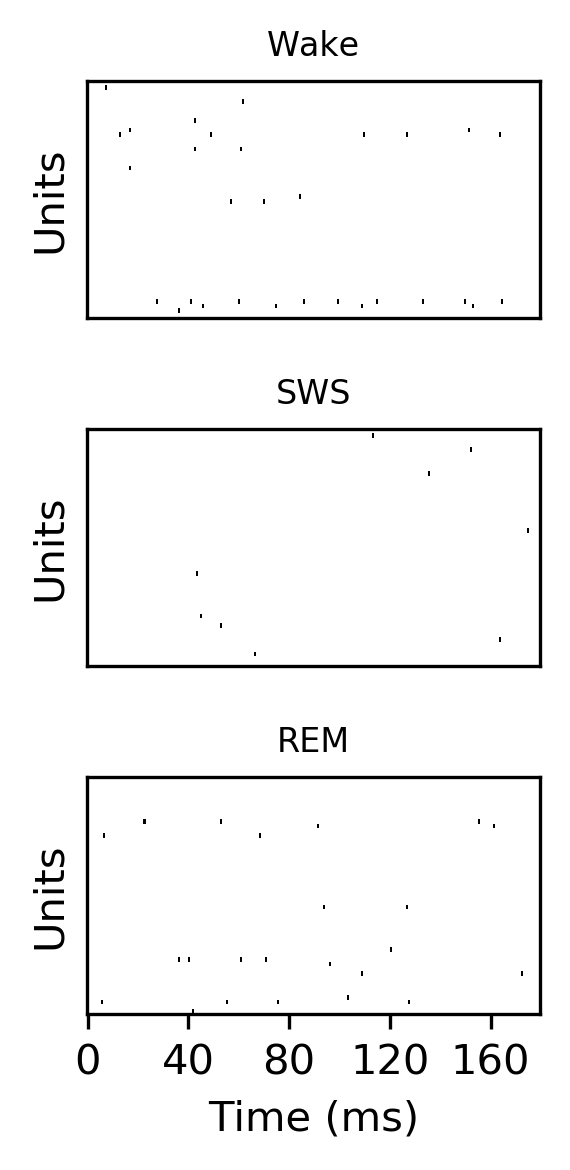

In [11]:
# plot spike trains

plt.figure(dpi = 300,figsize=(2,4))

plt.subplot(311)
plt.imshow(units_w[:,400:625],cmap = 'Greys',aspect = 'auto',interpolation = 'none')
plt.xticks([])
plt.yticks([])
plt.title('Wake',fontsize = 8)
plt.ylabel('Units')

plt.subplot(312)
plt.imshow(units_sws[:,1000:1225],cmap = 'Greys',aspect = 'auto',interpolation = 'none')
plt.xticks([])
plt.yticks([])
plt.title('SWS',fontsize = 8)
plt.ylabel('Units')

plt.subplot(313)
plt.imshow(units_rem[:,400:625],cmap = 'Greys',aspect = 'auto',interpolation = 'none')
plt.xticks([0,50,100,150,200],labels = [0,40,80,120,160])
plt.yticks([])
plt.title('REM',fontsize = 8)
plt.xlabel('Time (ms)')
plt.ylabel('Units')

plt.tight_layout()

In [13]:
# transform spike trains to counts and calculate recurrence plots

time_bin = 50 # time in msec to bin spike trains

spike_counts_w = spikes2counts(units_w,time_bin = time_bin, srate = srate) 
spike_counts_sws = spikes2counts(units_sws,time_bin = time_bin, srate = srate) 
spike_counts_rem = spikes2counts(units_rem,time_bin = time_bin, srate = srate) 

# recurrence plots from defined functions

error_level = 2 # number of spikes to define closeness in recurrence analysis
w_plot = recurrence_plot(spike_counts_w, error_level)
sws_plot = recurrence_plot(spike_counts_sws, error_level)
rem_plot = recurrence_plot(spike_counts_rem, error_level)

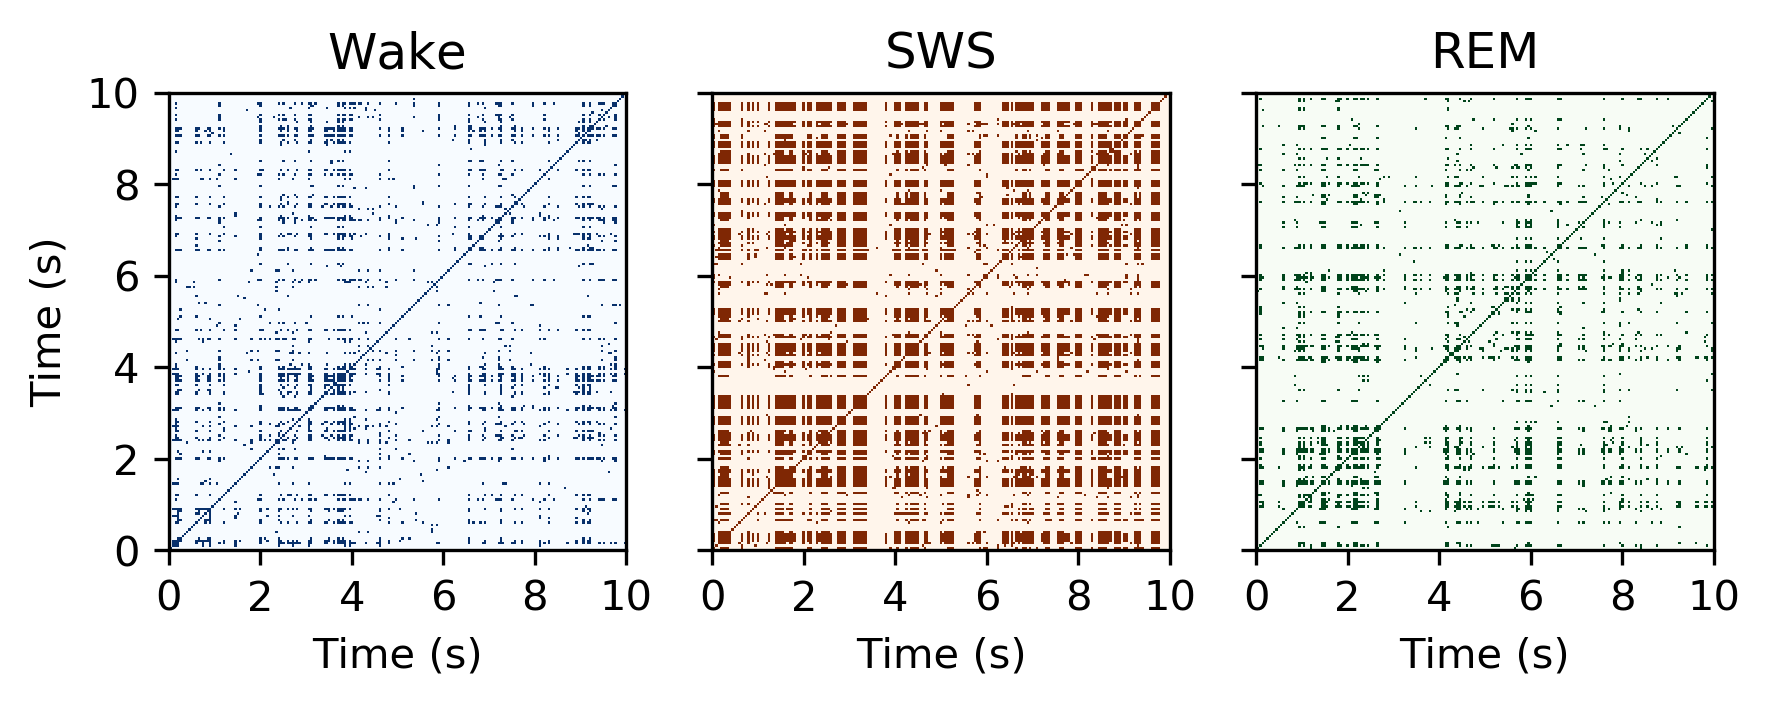

In [25]:
# plot recurrences for each sleep-wake state
plt.figure(dpi = 300)

plt.subplot(131)
plt.imshow(w_plot,'Blues',vmin = 0, vmax = 1,interpolation = 'Nearest')
plt.ylim(0,200)
plt.xlim(0,200)
plt.yticks(np.arange(0,220,40),labels = np.arange(0,12,2))
plt.xticks(np.arange(0,220,40),labels = np.arange(0,12,2))
plt.xlabel('Time (s)')
plt.ylabel('Time (s)')
plt.title('Wake')

plt.subplot(132)
plt.imshow(sws_plot,'Oranges',vmin = 0, vmax = 1,interpolation = 'Nearest')
plt.ylim(0,200)
plt.xlim(0,200)
plt.yticks(np.arange(0,220,40),labels = [])
plt.xticks(np.arange(0,220,40),labels = np.arange(0,12,2))
plt.xlabel('Time (s)')
plt.title('SWS')

plt.subplot(133)
plt.imshow(rem_plot,'Greens',vmin = 0, vmax = 1,interpolation = 'Nearest')
plt.ylim(0,200)
plt.xlim(0,200)
plt.yticks(np.arange(0,220,40),labels = [])
plt.xticks(np.arange(0,220,40),labels = np.arange(0,12,2))
plt.xlabel('Time (s)')
plt.title('REM')


plt.tight_layout()

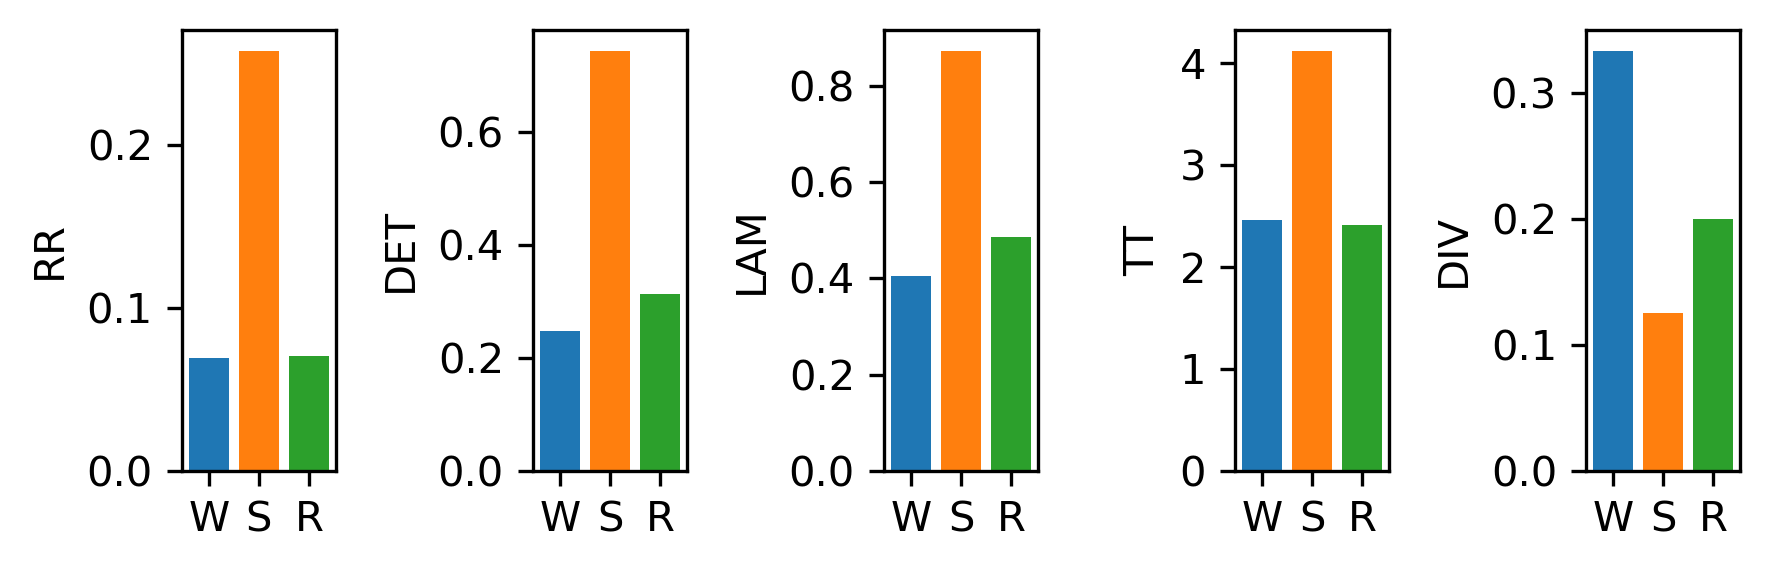

In [50]:
# recurrence quantification analysis

rr_w,divergence_w,determinism_w,trapping_time_w,laminarity_w = rqa(w_plot)
rr_sws,divergence_sws,determinism_sws,trapping_time_sws,laminarity_sws = rqa(sws_plot)
rr_rem,divergence_rem,determinism_rem,trapping_time_rem,laminarity_rem = rqa(rem_plot)

plt.figure(dpi = 300, figsize = (6,2))

plt.subplot(151)
plt.bar(1,rr_w)
plt.bar(2,rr_sws)
plt.bar(3,rr_rem)
plt.xticks([1,2,3],labels = ['W','S','R'])
plt.ylabel('RR')

plt.subplot(152)
plt.bar(1,determinism_w)
plt.bar(2,determinism_sws)
plt.bar(3,determinism_rem)
plt.xticks([1,2,3],labels = ['W','S','R'])
plt.ylabel('DET')

plt.subplot(153)
plt.bar(1,laminarity_w)
plt.bar(2,laminarity_sws)
plt.bar(3,laminarity_rem)
plt.xticks([1,2,3],labels = ['W','S','R'])
plt.ylabel('LAM')

plt.subplot(154)
plt.bar(1,trapping_time_w)
plt.bar(2,trapping_time_sws)
plt.bar(3,trapping_time_rem)
plt.xticks([1,2,3],labels = ['W','S','R'])
plt.ylabel('TT')

plt.subplot(155)
plt.bar(1,divergence_w)
plt.bar(2,divergence_sws)
plt.bar(3,divergence_rem)
plt.xticks([1,2,3],labels = ['W','S','R'])
plt.ylabel('DIV')

plt.tight_layout()
